In [1]:
import numpy as np
from scipy import ndimage
import tensorflow as tf
from os import listdir

#has package pillow as a dependency. Is needed to give scipy image operations. 
from scipy import misc
import scipy

from modules.utils import *
from modules.model import *

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import modules.vgg19 as vgg19
vgg_r = vgg19.Vgg19(vgg19_npy_path="data/vgg19.npy")
vgg_f = vgg19.Vgg19(vgg19_npy_path="data/vgg19.npy")

npy file loaded
npy file loaded


In [3]:
'''Constants'''
IMAGE_FOLDER_c1 = "data/zebras"
IMAGE_FOLDER_c2 = "data/horses"

BATCH_SIZE = 1
EPOCHS = 35

INPUT_SIZE = Dimensions(256, 256)

GEN_RATE = 0.001
DISC_RATE = 0.0005


DISC_REAL_COEF = 1
DISC_FAKE_COEF = 1
GEN_VGG_COEF = 0.00001
GEN_DISC_COEF = 1


In [4]:
'''Load data'''
image_names_c1 = listdir(IMAGE_FOLDER_c1)
image_names_c2 = listdir(IMAGE_FOLDER_c2)
image_paths_c1 = [IMAGE_FOLDER_c1 + '/' + name for name in image_names_c1[0:10000]]
image_paths_c2 = [IMAGE_FOLDER_c2 +'/' + name for name in image_names_c2[0:10000]]
print(len(image_paths_c1))
print(len(image_paths_c2))

1334
1067


In [5]:
def showImagesHorizontally(list_of_files):
    fig = plt.figure(figsize=(16, 12))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        plt.imshow(list_of_files[i])
        plt.axis('off')

def save_output(image, number):
    misc.imsave("data/generated_output/output_"+str(number)+".png", image)

def discriminator(in_tensor):
    discriminator = Model("Discriminator", in_tensor)
    discriminator.full_conv2d(3,64, stride=1)
    discriminator.lrelu()
    
    discriminator.full_conv2d(64,150, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    discriminator.full_conv2d(150,250, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    
    discriminator.full_conv2d(250,400, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    discriminator.full_conv2d(400,500, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    
    discriminator.full_conv2d(500,1000, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    discriminator.full_conv2d(1000,2000, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    
    discriminator.add_residual_block(2000, 2000)
    discriminator.add_residual_block(2000, 2000)
    #discriminator.full_conv2d(2000, 512, stride=1)
    
    discriminator.dense(2000*4,512*4)
    discriminator.lrelu()
    discriminator.dense(512*4,1)
    return discriminator

def patch_discriminator(in_tensor):
    discriminator = Model("Patch_discriminator", in_tensor)
    
    ksizes = [1, 32, 32, 1]
    strides = [1, 16, 16, 1]
    rates = [1, 1, 1, 1]
    padding = 'VALID'
    
    discriminator.image_patches(ksizes, strides, rates, padding)
    discriminator.reshape([-1,32,32,3])
    
    discriminator.full_conv2d(3,64, stride=2)
    discriminator.lrelu()
    discriminator.full_conv2d(64,128, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    discriminator.full_conv2d(128,256, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    discriminator.full_conv2d(256,256, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    
    discriminator.dense(1024,1024)
    discriminator.lrelu()
    discriminator.dense(1024,1)
    
    return discriminator

def generator(in_tensor):
    generator = Model("Generator", in_tensor)
    
    #todo: add droput? 
    
    generator.full_conv2d(3,64, stride=1) 
    generator.batch_norm()
    generator.lrelu()
    skip_1 = generator.get_output() #64 @ 128
    
    generator.full_conv2d(64,128, stride=2) 
    generator.batch_norm()
    generator.lrelu()
    
    generator.full_conv2d(128,256, stride=2) 
    generator.batch_norm()
    generator.lrelu()
    skip_2 = generator.get_output() # 30 @ 256  
    
    generator.full_conv2d(256,512, stride=2) 
    generator.batch_norm()
    generator.lrelu()
    
    generator.full_conv2d(512,1024, stride=2) 
    generator.batch_norm()
    generator.lrelu()
    skip_3 = generator.get_output() #16 @ 1024
    
    generator.full_conv2d(1024,1024, stride=2) # 8x8
    generator.batch_norm()
    generator.lrelu()
    
    generator.add_residual_block(1024, 1024)
    generator.add_residual_block(1024, 1024)
    generator.add_residual_block(1024, 1024)
    generator.add_residual_block(1024, 1024)
    
    generator.upscale([16,16])
    generator.channel_concat(skip_3)
    generator.full_conv2d(1024*2,512, stride=1) #16
    generator.batch_norm()
    generator.dropout(0.5)
    generator.lrelu()

    generator.upscale([32,32])
    generator.full_conv2d(512,256, stride=1) #16
    generator.batch_norm()
    generator.dropout(0.5)
    generator.lrelu()
    
    generator.upscale([64,64])
    generator.channel_concat(skip_2)
    generator.full_conv2d(256*2,128, stride=1) 
    generator.batch_norm()
    generator.dropout(0.5)
    generator.lrelu()

    generator.upscale([128,128])
    generator.full_conv2d(128,64, stride=1) 
    generator.batch_norm()
    generator.dropout(0.5)
    generator.lrelu()


    generator.upscale([256,256])
    generator.channel_concat(skip_1)
    generator.full_conv2d(64*2,64*2, stride=1) 
    generator.batch_norm()
    generator.lrelu()
    
    generator.add_residual_block(128, 128)
    generator.add_residual_block(128, 128)
    generator.full_conv2d(128,3, mapsize = 1)
    '''
    
    generator.full_conv2d(3,256)
    generator.add_residual_block(256, 256)
    generator.add_residual_block(256, 256)
    generator.add_residual_block(256, 256)
    generator.add_residual_block(256, 256)
    generator.add_residual_block(256, 256)
    generator.add_residual_block(256, 256)
    generator.add_residual_block(256, 256)
    generator.add_residual_block(256, 256)
    generator.add_residual_block(256, 256)
    generator.add_residual_block(256, 256)
    generator.add_residual_block(256, 256)
    generator.add_residual_block(256, 256)
    generator.full_conv2d(256,3)
    '''
    generator.rgb_bound()
    #generator.tanh_rgb_bound()
    return generator

In [6]:
disc_real_input = tf.placeholder('float32', shape = [BATCH_SIZE, INPUT_SIZE.h, INPUT_SIZE.w, 3])
gen_input = tf.placeholder('float32',shape = [BATCH_SIZE, INPUT_SIZE.h,INPUT_SIZE.w,3])

#Generator
generator_model = generator(gen_input)
gen_output = generator_model.outputs[-2]


#Discriminator
with tf.variable_scope('disc') as scope:
    disc_model_r = discriminator(disc_real_input)
    scope.reuse_variables()
    disc_model_f = discriminator(gen_output)

    
#fake_model = patch_discriminator(disc_real_input)
    
#vgg
#with tf.variable_scope('vgg') as scope: 
vgg_r.build(gen_input, dimension = INPUT_SIZE.h)
    #scope.reuse_variables()
vgg_f.build(generator_model.get_output(), dimension = INPUT_SIZE.h)
    
    
#discriminator loss
disc_c1 = tf.nn.sigmoid_cross_entropy_with_logits(disc_model_r.get_output(), tf.ones_like(disc_model_r.get_output()))
disc_c2 = tf.nn.sigmoid_cross_entropy_with_logits(disc_model_f.get_output(), tf.zeros_like(disc_model_f.get_output()))

disc_loss = DISC_REAL_COEF*tf.reduce_mean(disc_c1)+DISC_FAKE_COEF*tf.reduce_mean(disc_c2)
disc_opt = tf.train.AdamOptimizer(learning_rate=DISC_RATE).minimize(disc_loss, var_list = disc_model_f.variables)

#Generator Loss

#vgg loss
diff = tf.reshape(vgg_r.conv4_4, [BATCH_SIZE,-1]) - tf.reshape(vgg_f.conv4_4, [BATCH_SIZE,-1])
vgg_mse = tf.reduce_mean(tf.abs(diff))*GEN_VGG_COEF

#disc loss
gen_ce = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(disc_model_f.get_output(), tf.ones_like(disc_model_f.get_output())))

#combined
gen_loss = GEN_DISC_COEF*gen_ce + vgg_mse
gen_opt = tf.train.AdamOptimizer(learning_rate=GEN_RATE).minimize(gen_loss,var_list = generator_model.variables)
gen_img = tf.cast(generator_model.get_output(), dtype=tf.uint8)

build model started
build model finished: 0s
build model started
build model finished: 0s


In [7]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [8]:
image_gen_c1 = minibatch_image_generator(image_paths_c1[0:(len(image_paths_c1)//BATCH_SIZE)*BATCH_SIZE],BATCH_SIZE)
image_gen_c2 = minibatch_image_generator(image_paths_c2[0:(len(image_paths_c2)//BATCH_SIZE)*BATCH_SIZE],BATCH_SIZE)
print("generating images") 
_,image_batch_c1 = next(image_gen_c1)
_,image_batch_c2 = next(image_gen_c2)
print("generated images") 

generating images
generated images


In [9]:
#Setting up sample saving
_,image_batch_c1 = next(image_gen_c1)
_,image_batch_c2 = next(image_gen_c2)
fd_sample = {disc_real_input:image_batch_c1, gen_input:image_batch_c2}

In [10]:
saver = tf.train.Saver()

In [11]:
#epoch,image_batch_c2 = next(image_gen_c2)
#test
try:
    index = 0
    steps = 10000
    while(index < steps):
        index = index + 1
        _,image_batch_c1 = next(image_gen_c1)
        _,image_batch_c2 = next(image_gen_c2)
        
        fd = {disc_real_input:image_batch_c1, gen_input:image_batch_c2}
        sess.run(disc_opt, feed_dict = fd)
        
        _,image_batch_c2 = next(image_gen_c2)
        fd = {gen_input:image_batch_c2}
        sess.run(gen_opt, feed_dict = fd)
        
        _,image_batch_c2 = next(image_gen_c2)
        fd = {gen_input:image_batch_c2}
        sess.run(gen_opt, feed_dict = fd)
        
        if(index % 1000 == 0):        
            
            _,image_batch_c1 = next(image_gen_c1)
            _,image_batch_c2 = next(image_gen_c2)
            fd = {disc_real_input:image_batch_c1, gen_input:image_batch_c2}
            (g_comb_error, g_vgg_error, g_disc_error, d_error) = sess.run([gen_loss, vgg_mse, gen_ce, disc_loss], feed_dict = fd)
            print('step {}, gcom_loss {:01.2f}, gvgg_e {:01.2f}, gdisc_e {:01.2f}, d_loss {:01.2f}'.format(index,g_comb_error, g_vgg_error, g_disc_error, d_error))
            (sample) = sess.run(gen_img,feed_dict=fd_sample)
            save_output(sample[0],index)
            #saver.save(sess, 'saves/s', global_step=index)
except KeyboardInterrupt:
    pass #avoids getting KeyboardInterrupt errors when stopping training early
except:
    raise

In [2]:
index

17001

In [12]:
epoch,image_batch_c1 = next(image_gen_c1)
epoch,image_batch_c2 = next(image_gen_c2)
fd_sample = {disc_real_input:image_batch_c1, gen_input:image_batch_c2}
(sample) = sess.run(gen_img,feed_dict=fd_sample)

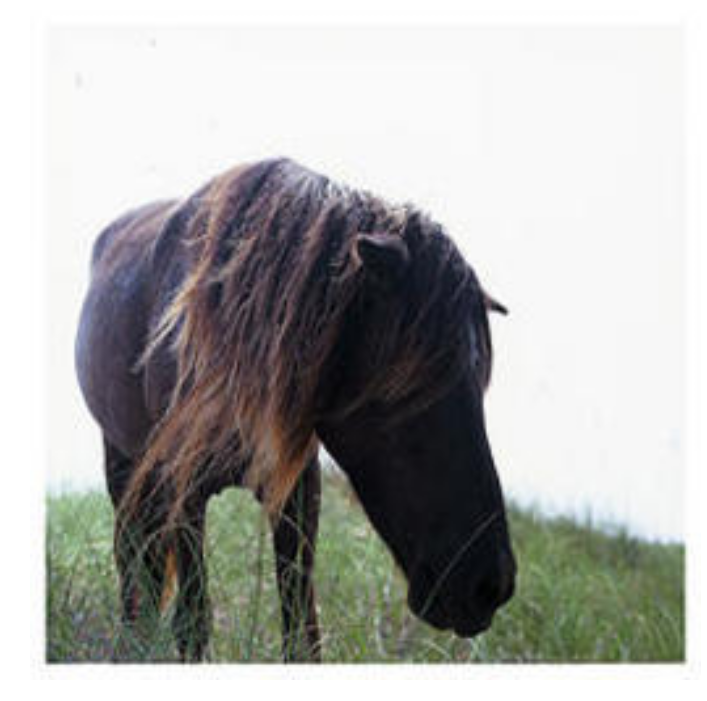

In [13]:
showImagesHorizontally(image_batch_c2[0:6])

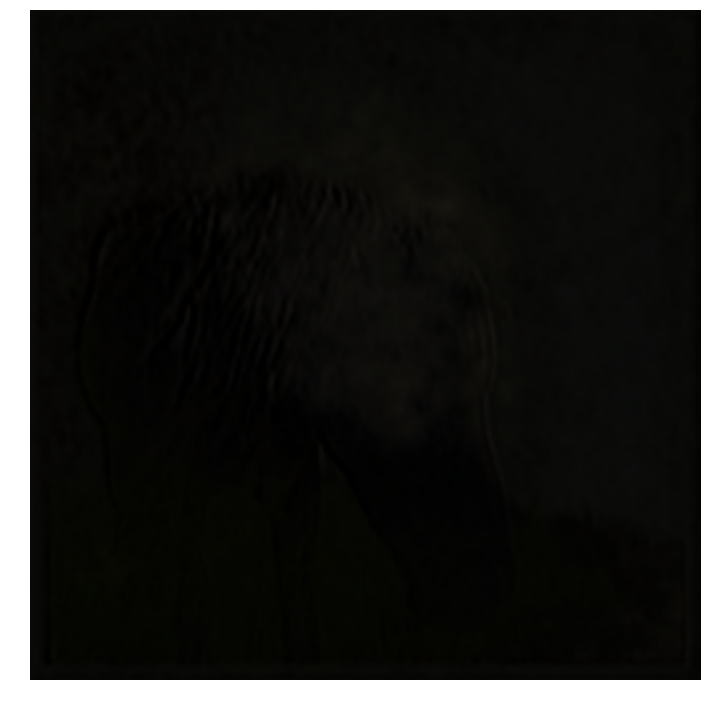

In [14]:
showImagesHorizontally(sample[0:6])

In [10]:
fd = {disc_real_input:image_batch_c1, gen_input:image_batch_c1}
sess.run(tf.shape(fake_model.get_output()), fd)

array([  20,    3,    3, 3072], dtype=int32)

In [30]:
sample_num =  sample_num + 1
misc.imsave("data/generated_output/input_"+str(sample_num)+".png", image_batch_c2[0])
misc.imsave("data/generated_output/output_"+str(sample_num)+".png", sample[0])
sample_num

6

In [19]:
#Clears everything
sess.close()
tf.reset_default_graph()

In [16]:
saver = tf.train.Saver()


In [17]:
saver.save(sess, 'saves/s', global_step=1)

'saves/s-1'

In [12]:
saver.restore(sess,'saves/s-1')